This is to calculate $P_e$ and $J_0$ of multiple glaciers in Greenland using the flowline location provided by Felikson et al (2021).

This version tests different flowlines in the same basin.

The $P_e$ and $J_0$ are then compared with the glacier speed change during 1998-2018 from the ITS_LIVE data set.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pjgris import my_savgol_filter, savgol_smoothing, pe_corefun, cal_pej0_for_each_flowline, cal_avg_for_each_basin
import rasterio
import utils
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [3]:
netcdf_dir = '/home/jovyan/Projects/LubriSens/Data/Felikson2021/netcdfs'
glacier_file = netcdf_dir + '/glacier0207.nc'
speed_file = '/home/jovyan/Projects/LubriSens/Data/ITSLIVE/GRE_G0240_1998_v.tif'
vdiff_file = '/home/jovyan/Projects/LubriSens/Data/ITSLIVE/GRE_G0240_diff-2018-1998_v.tif'

In [4]:
ds = Dataset(glacier_file, 'r')
flowline_groups, _ = utils.get_flowline_groups(ds)
primary_flowlines = [i for i in flowline_groups if 'iter' not in i.path]

speed_data = rasterio.open(speed_file)
vdiff_data = rasterio.open(vdiff_file)

In [5]:
results = {}

for flowline_group in primary_flowlines:

    # print(flowline_group)
    data_group = cal_pej0_for_each_flowline(flowline_group, speed_data, vdiff_data)

    if data_group is not None:
        results[flowline_group.name] = data_group
        
results['avg'] = cal_avg_for_each_basin(results)
# results

In [6]:
flowline_group['geometry']['surface']['GIMP']['nominal']['h'][:]
# flowline_obj['d'][:]

masked_array(data=[ 198.89407,  204.01013,  208.83228, ..., 2576.691  ,
                   2576.8853 , 2577.     ],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

(0.0, 20.149999618530273)

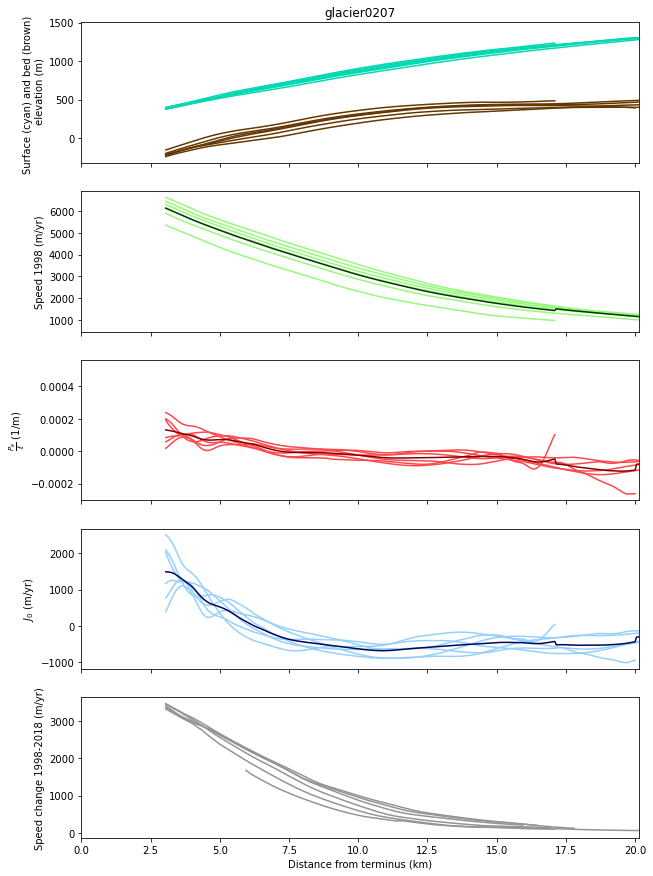

In [7]:
# results

fig, ax1 = plt.subplots(5, 1, sharex=True, figsize=(10, 15))
for key in results:
    if key != 'avg':
        ax1[0].plot(results[key]['d'], results[key]['s'], color='xkcd:aquamarine')
        ax1[0].plot(results[key]['d'], results[key]['b'], color='xkcd:brown')
        ax1[1].plot(results[key]['d'], results[key]['u'], color='xkcd:light green')
        ax1[2].plot(results[key]['d'], results[key]['pe'], color='xkcd:light red')
        ax1[3].plot(results[key]['d'], results[key]['j0'], color='xkcd:light blue')
        ax1[4].plot(results[key]['d'], results[key]['udiff_sm'], color='xkcd:gray')
    else:
        ax1[1].plot(results[key]['d'], results[key]['u'], color='xkcd:dark green')
        ax1[2].plot(results[key]['d'], results[key]['pe'], color='xkcd:dark red')
        ax1[3].plot(results[key]['d'], results[key]['j0'], color='xkcd:dark blue')

ax1[0].set_title(Path(glacier_file).stem)
ax1[0].set_ylabel('Surface (cyan) and bed (brown) \n elevation (m)')
ax1[1].set_ylabel('Speed 1998 (m/yr)')
ax1[2].set_ylabel(r'$\frac{P_e}{\ell}$ (1/m)')
# ax1[2].set_ylim([-0.001, 0.001])
ax1[3].set_ylabel(r'$J_0$ (m/yr)')
# ax1[3].set_ylim([-3000, 3000])
ax1[4].set_xlabel('Distance from terminus (km)')
ax1[4].set_ylabel('Speed change 1998-2018 (m/yr)')
ax1[4].set_xlim([0, results['avg']['d'][-1]])

(0.0, 20.149999618530273)

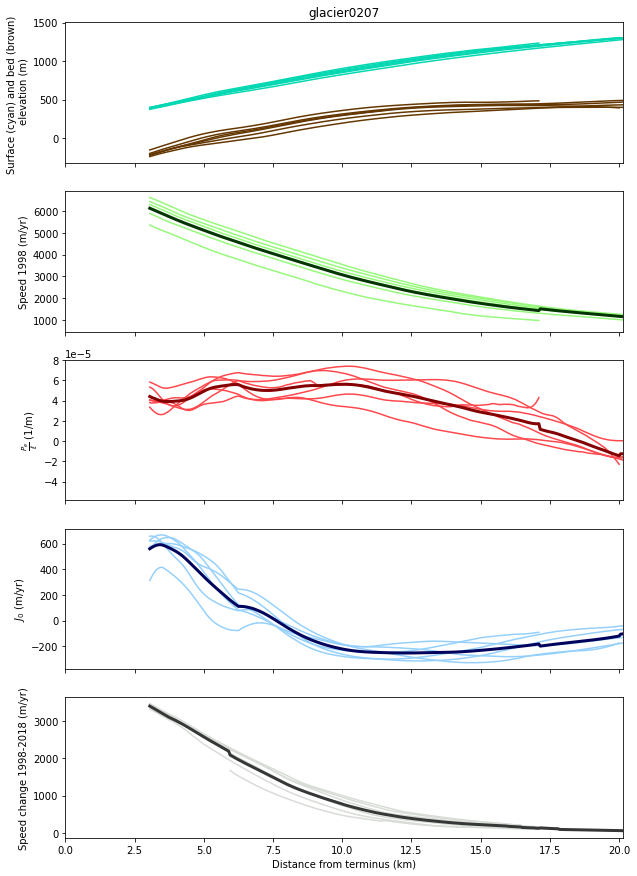

In [8]:
# results

fig, ax1 = plt.subplots(5, 1, sharex=True, figsize=(10, 15))
for key in results:
    if key != 'avg':
        ax1[0].plot(results[key]['d'], results[key]['s'], color='xkcd:aquamarine')
        ax1[0].plot(results[key]['d'], results[key]['b'], color='xkcd:brown')
        ax1[1].plot(results[key]['d'], results[key]['u'], color='xkcd:light green')
        ax1[2].plot(results[key]['d'], results[key]['pe_ignore_dslope'], color='xkcd:light red')
        ax1[3].plot(results[key]['d'], results[key]['j0_ignore_dslope'], color='xkcd:light blue')
        ax1[4].plot(results[key]['d'], results[key]['udiff_sm'], color='xkcd:light grey')
    else:
        ax1[1].plot(results[key]['d'], results[key]['u'], color='xkcd:dark green', linewidth=3)
        ax1[2].plot(results[key]['d'], results[key]['pe_ignore_dslope'], color='xkcd:dark red', linewidth=3)
        ax1[3].plot(results[key]['d'], results[key]['j0_ignore_dslope'], color='xkcd:dark blue', linewidth=3)
        ax1[4].plot(results[key]['d'], results[key]['udiff_sm'], color='xkcd:dark grey', linewidth=3)

ax1[0].set_title(Path(glacier_file).stem)
ax1[0].set_ylabel('Surface (cyan) and bed (brown) \n elevation (m)')
ax1[1].set_ylabel('Speed 1998 (m/yr)')
ax1[2].set_ylabel(r'$\frac{P_e}{\ell}$ (1/m)')
# ax1[2].set_ylim([-0.001, 0.001])
ax1[3].set_ylabel(r'$J_0$ (m/yr)')
# ax1[3].set_ylim([-3000, 3000])
ax1[4].set_xlabel('Distance from terminus (km)')
ax1[4].set_ylabel('Speed change 1998-2018 (m/yr)')
ax1[4].set_xlim([0, results['avg']['d'][-1]])

Text(0.5, 1.0, 'glacier0207( Dot spacing: 50 m)')

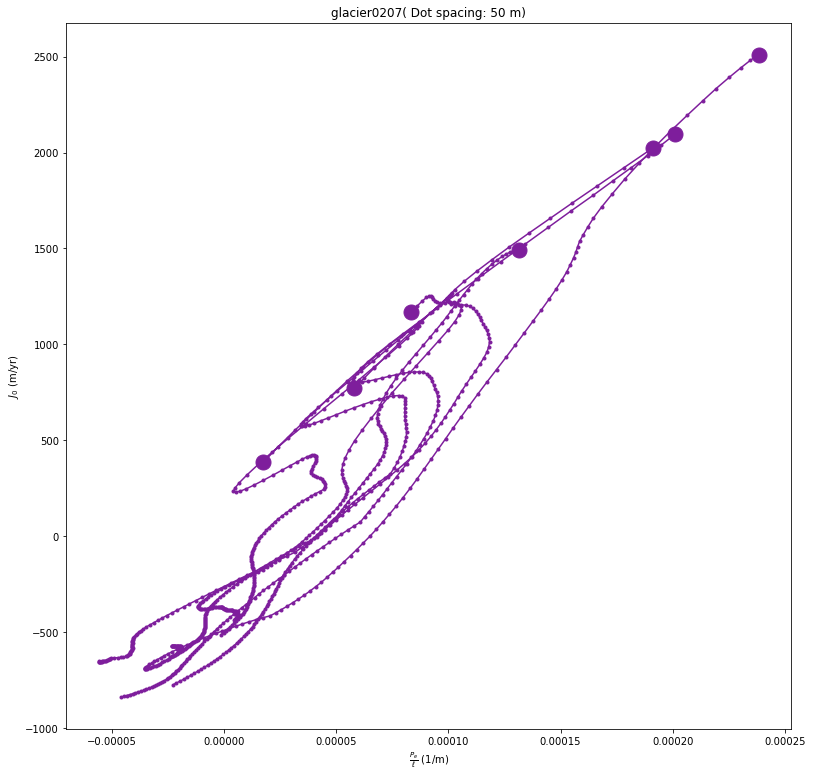

In [9]:
fig, ax2 = plt.subplots(1, 1, figsize=(13, 13))
for key in results:
    length = 200
    ax2.plot(results[key]['pe'][:length], results[key]['j0'][:length], '.-', color='xkcd:purple')
    # plot first non-NaN value (the one closest to the terminus)
    ax2.plot(next(x for x in results[key]['pe'][:length] if not np.isnan(x)),
             next(x for x in results[key]['j0'][:length] if not np.isnan(x)), '.', color='xkcd:purple', markersize=30)
    
ax2.set_xlabel(r'$\frac{P_e}{\ell}$ (1/m)')
ax2.set_ylabel(r'$J_0$ (m/yr)')
ax2.set_title(Path(glacier_file).stem + '( Dot spacing: 50 m)')

Text(0.5, 1.0, 'glacier0207( Dot spacing: 50 m)')

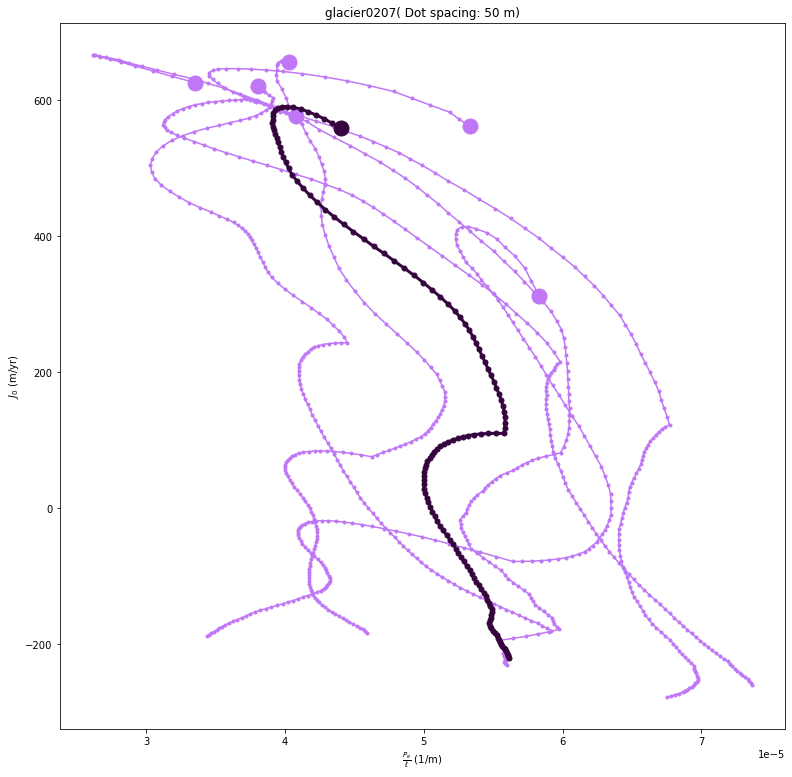

In [10]:
fig, ax2 = plt.subplots(1, 1, figsize=(13, 13))
for key in results:
    length = 200
    if key != 'avg':
        ax2.plot(results[key]['pe_ignore_dslope'][:length], results[key]['j0_ignore_dslope'][:length], '.-', color='xkcd:light purple')
        # plot first non-NaN value (the one closest to the terminus)
        ax2.plot(next(x for x in results[key]['pe_ignore_dslope'][:length] if not np.isnan(x)),
                 next(x for x in results[key]['j0_ignore_dslope'][:length] if not np.isnan(x)), '.', color='xkcd:light purple', markersize=30)
    else:
        ax2.plot(results[key]['pe_ignore_dslope'][:length], results[key]['j0_ignore_dslope'][:length], '.-', color='xkcd:dark purple', linewidth=3, markersize=10)
        # plot first non-NaN value (the one closest to the terminus)
        ax2.plot(next(x for x in results[key]['pe_ignore_dslope'][:length] if not np.isnan(x)),
                 next(x for x in results[key]['j0_ignore_dslope'][:length] if not np.isnan(x)), '.', color='xkcd:dark purple', markersize=30)
    
ax2.set_xlabel(r'$\frac{P_e}{\ell}$ (1/m)')
ax2.set_ylabel(r'$J_0$ (m/yr)')
ax2.set_title(Path(glacier_file).stem + '( Dot spacing: 50 m)')

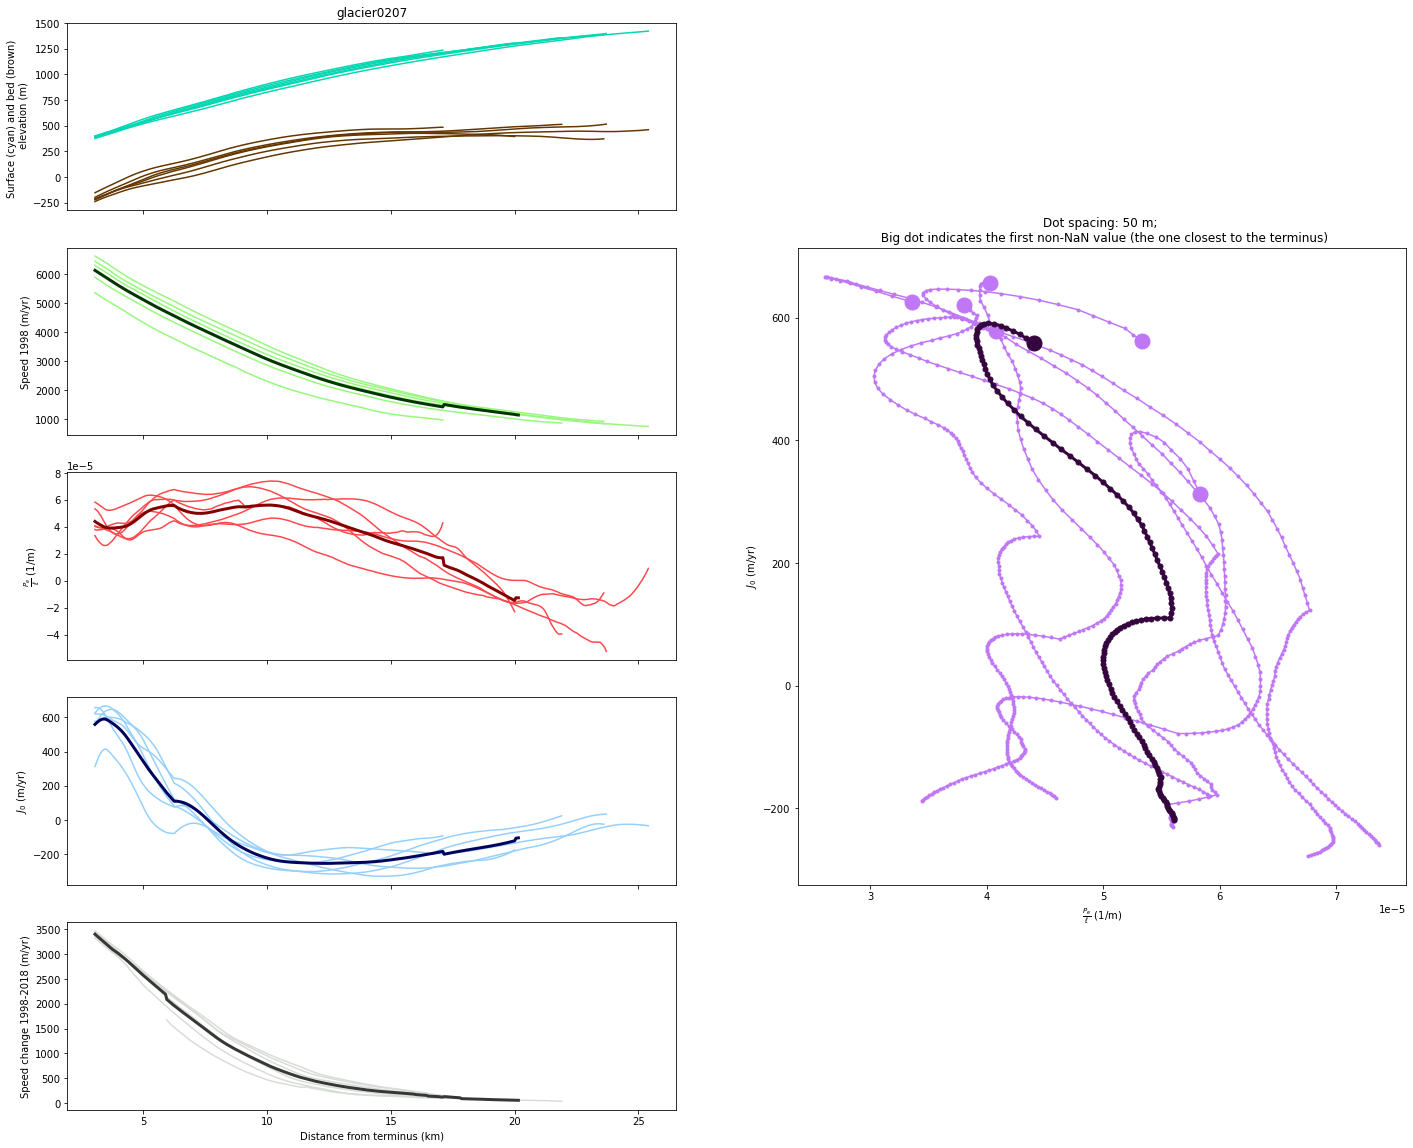

In [11]:
fig, ax3 = plt.subplots(5, 2, sharex=True, figsize=(24, 20))
gs = ax3[1, 1].get_gridspec()
for ax in ax3[:, 1]:
    ax.remove()
axbig = fig.add_subplot(gs[1:4, 1])
pej0_plot_length = 200

for key in results:

    if key != 'avg':
        ax3[0, 0].plot(results[key]['d'], results[key]['s'], color='xkcd:aquamarine')
        ax3[0, 0].plot(results[key]['d'], results[key]['b'], color='xkcd:brown')
        ax3[1, 0].plot(results[key]['d'], results[key]['u'], color='xkcd:light green')
        ax3[2, 0].plot(results[key]['d'], results[key]['pe_ignore_dslope'], color='xkcd:light red')
        ax3[3, 0].plot(results[key]['d'], results[key]['j0_ignore_dslope'], color='xkcd:light blue')
        # ax3[2, 0].plot(results[key]['d'], results[key]['pe'], color='xkcd:light red')
        # ax3[3, 0].plot(results[key]['d'], results[key]['j0'], color='xkcd:light blue')
        ax3[4, 0].plot(results[key]['d'], results[key]['udiff_sm'], color='xkcd:light grey')
        axbig.plot(results[key]['pe_ignore_dslope'][:pej0_plot_length], results[key]['j0_ignore_dslope'][:pej0_plot_length], '.-', color='xkcd:light purple')
        # axbig.plot(results[key]['pe'][:pej0_plot_length], results[key]['j0'][:pej0_plot_length], '.-', color='xkcd:light purple')
        # plot first non-NaN value (the one closest to the terminus)
        axbig.plot(next(x for x in results[key]['pe_ignore_dslope'][:pej0_plot_length] if not np.isnan(x)),
                   next(x for x in results[key]['j0_ignore_dslope'][:pej0_plot_length] if not np.isnan(x)), '.', color='xkcd:light purple', markersize=30)
        # axbig.plot(next(x for x in results[key]['pe'][:pej0_plot_length] if not np.isnan(x)),
        #            next(x for x in results[key]['j0'][:pej0_plot_length] if not np.isnan(x)), '.', color='xkcd:light purple', markersize=30)
    else:
        ax3[1, 0].plot(results[key]['d'], results[key]['u'], color='xkcd:dark green', linewidth=3)
        ax3[2, 0].plot(results[key]['d'], results[key]['pe_ignore_dslope'], color='xkcd:dark red', linewidth=3)
        ax3[3, 0].plot(results[key]['d'], results[key]['j0_ignore_dslope'], color='xkcd:dark blue', linewidth=3)
        # ax3[2, 0].plot(results[key]['d'], results[key]['pe'], color='xkcd:dark red', linewidth=3)
        # ax3[3, 0].plot(results[key]['d'], results[key]['j0'], color='xkcd:dark blue', linewidth=3)
        ax3[4, 0].plot(results[key]['d'], results[key]['udiff_sm'], color='xkcd:dark grey', linewidth=3)
        axbig.plot(results[key]['pe_ignore_dslope'][:pej0_plot_length], results[key]['j0_ignore_dslope'][:pej0_plot_length], '.-', color='xkcd:dark purple', linewidth=3, markersize=10)
        # axbig.plot(results[key]['pe'][:pej0_plot_length], results[key]['j0'][:pej0_plot_length], '.-', color='xkcd:dark purple', linewidth=3, markersize=10)
        # plot first non-NaN value (the one closest to the terminus)
        axbig.plot(next(x for x in results[key]['pe_ignore_dslope'][:pej0_plot_length] if not np.isnan(x)),
                 next(x for x in results[key]['j0_ignore_dslope'][:pej0_plot_length] if not np.isnan(x)), '.', color='xkcd:dark purple', markersize=30)
        # axbig.plot(next(x for x in results[key]['pe'][:pej0_plot_length] if not np.isnan(x)),
        #          next(x for x in results[key]['j0'][:pej0_plot_length] if not np.isnan(x)), '.', color='xkcd:dark purple', markersize=30)
        
    
ax3[0, 0].set_title(Path(glacier_file).stem)
ax3[0, 0].set_ylabel('Surface (cyan) and bed (brown) \n elevation (m)')
ax3[1, 0].set_ylabel('Speed 1998 (m/yr)')
ax3[2, 0].set_ylabel(r'$\frac{P_e}{\ell}$ (1/m)')
ax3[3, 0].set_ylabel(r'$J_0$ (m/yr)')
ax3[4, 0].set_xlabel('Distance from terminus (km)')
ax3[4, 0].set_ylabel('Speed change 1998-2018 (m/yr)')
axbig.set_xlabel(r'$\frac{P_e}{\ell}$ (1/m)')
axbig.set_ylabel(r'$J_0$ (m/yr)')
axbig.set_title('Dot spacing: 50 m; \n Big dot indicates the first non-NaN value (the one closest to the terminus)')

plt.savefig('tmp.png')

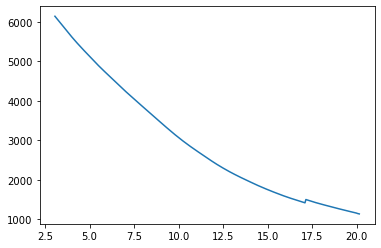

In [18]:
plt.plot(results['avg']['d'], results['avg']['u'])

In [23]:
x = np.linspace(1,10000,10000)
# x

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100.])

In [37]:
print(results['avg']['d'][:101])
print(results['avg']['b'][:101])

[0.0 0.05000000074505806 0.10000000149011612 0.15000000596046448
 0.20000000298023224 0.25 0.30000001192092896 0.3499999940395355
 0.4000000059604645 0.44999998807907104 0.5 0.550000011920929
 0.6000000238418579 0.6499999761581421 0.699999988079071 0.75
 0.800000011920929 0.8500000238418579 0.8999999761581421 0.949999988079071
 1.0 1.0499999523162842 1.100000023841858 1.149999976158142
 1.2000000476837158 1.25 1.2999999523162842 1.350000023841858
 1.399999976158142 1.4500000476837158 1.5 1.5499999523162842
 1.600000023841858 1.649999976158142 1.7000000476837158 1.75
 1.7999999523162842 1.850000023841858 1.899999976158142 1.9500000476837158
 2.0 2.049999952316284 2.0999999046325684 2.1500000953674316
 2.200000047683716 2.25 2.299999952316284 2.3499999046325684
 2.4000000953674316 2.450000047683716 2.5 2.549999952316284
 2.5999999046325684 2.6500000953674316 2.700000047683716 2.75
 2.799999952316284 2.8499999046325684 2.9000000953674316 2.950000047683716
 3.0 3.049999952316284 3.09999990